In [1]:

import numpy as np
import torch
from scipy.integrate import odeint
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from torch import nn, autograd


In [2]:
# Define a function to solve the Duffing equation numerically
def solve_duffing(d, a, b, gamma, w, x):
    def duffing(y, t):
        y0, y1 = y
        dydt = [y1, -d * y1 - a * y0 - b * y0**3 + gamma * np.cos(w * t)]
        return dydt

    y0 = [0, 0]  
    sol = odeint(duffing, y0, x.view(-1).numpy())  # Convert x to a one-dimensional numpy array
    y = torch.tensor(sol[:, 0])
    return y


In [3]:
# Define a class to create a fully connected neural network
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
                # Assuming your linear layer is named `layer`
        input_size = self.fce.in_features
        print("Input size of the linear layer:", input_size)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [4]:


  
# Set up the parameters and the training data for the model
d = 0.5
a = 0.0
b = 0.0 
gamma = 10
w = 10
x = torch.linspace(0, 1, 500).view(-1,1) 
y = solve_duffing(d, a, b, gamma, w, x).view(-1,1)
y_data = y[0:200:20]
x_data = x[0:200:20]
displacement_data = []
velocity_data = []   

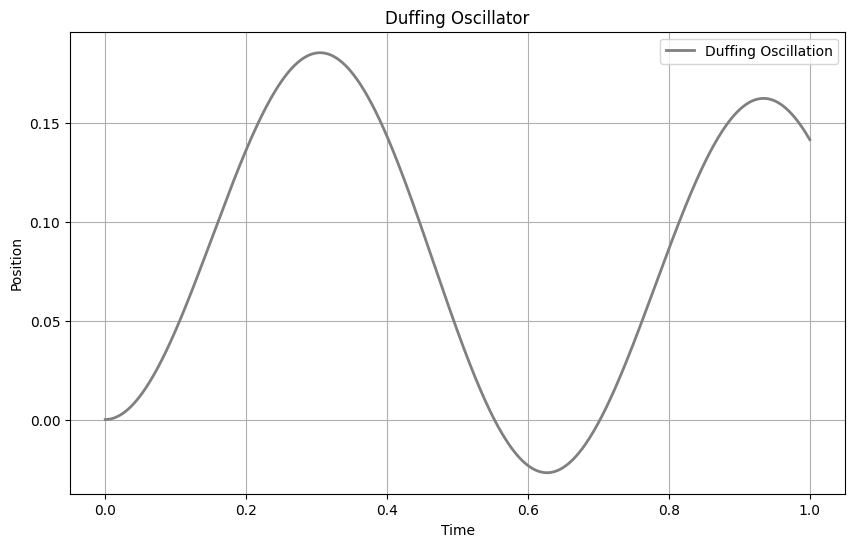

In [5]:


def plot_duffing_oscillator(d, a, b, gamma, w, x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(x.view(-1).numpy(), y.view(-1).numpy(), label='Duffing Oscillation', color="grey", linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Duffing Oscillator')
    plt.legend()
    plt.grid(True)
    plt.show()  # Display the plot immediately

# Plot the Duffing oscillator data
plot_duffing_oscillator(d, a, b, gamma, w, x, y)
plt.show()

Input size of the linear layer: 32
Loss at Step 1000 : 0.0001810701621079212


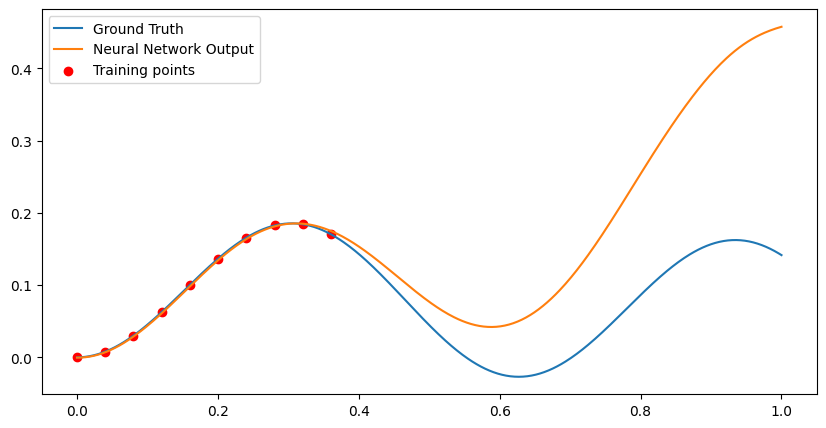

Loss at Step 2000 : 0.00012464625100122275


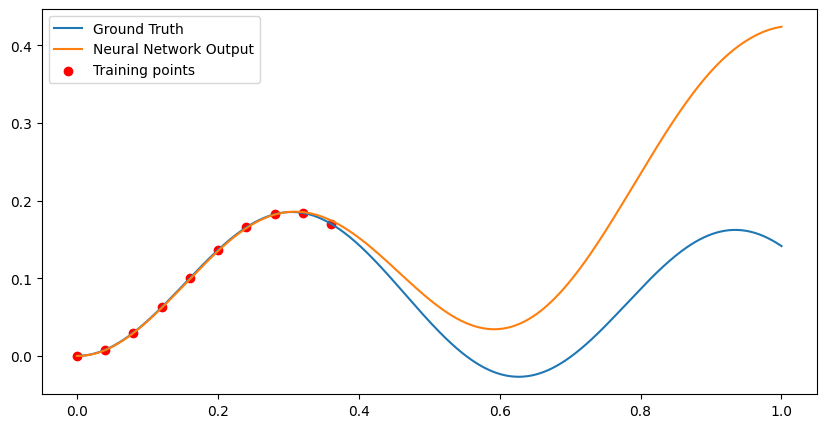

Loss at Step 3000 : 2.147753345433793e-06


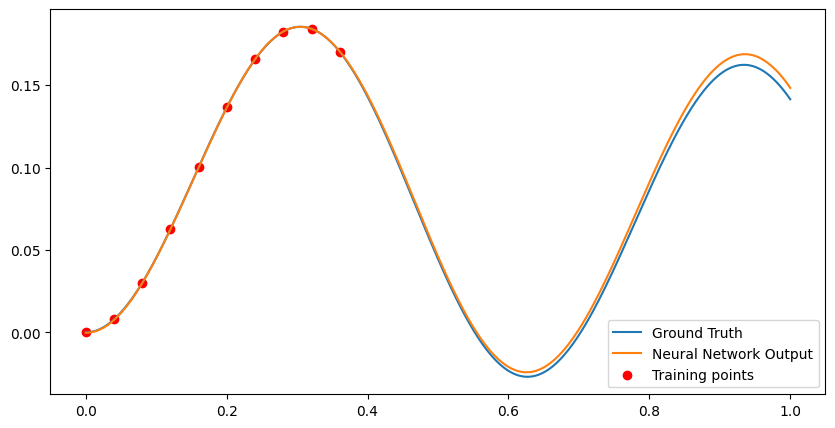

Loss at Step 4000 : 1.4558425185427425e-06


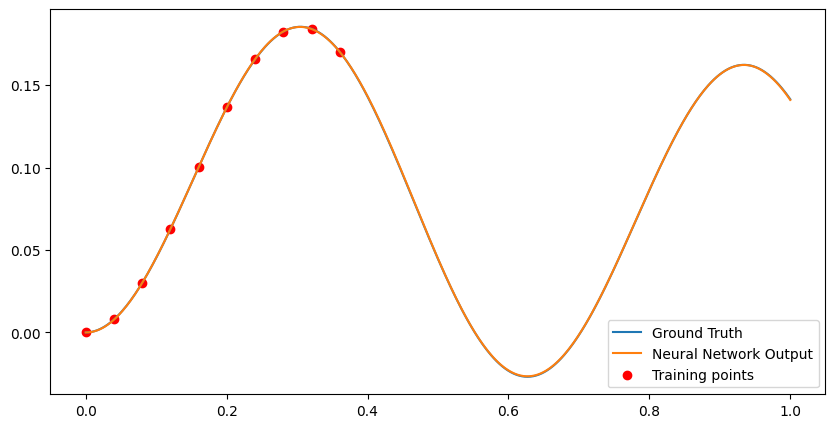

Loss at Step 5000 : 8.282710174826591e-07


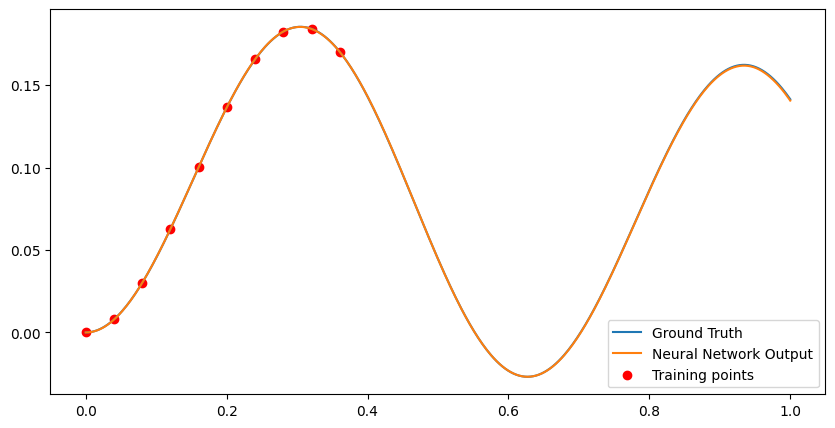

Loss at Step 6000 : 3.364551083763978e-06


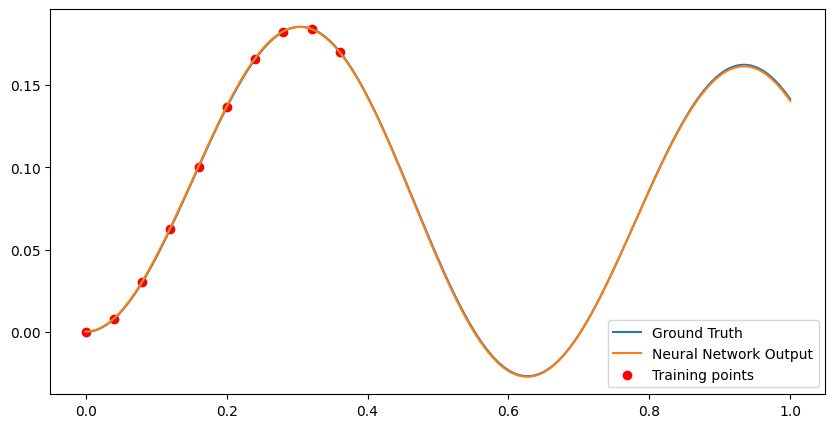

In [6]:





# Set up the physics loss training locations
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# Set up the random seed and initialize the model and optimizer
torch.manual_seed(123)
model = FCN(1,1,32,12)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Set up the boundary conditions
X_BOUNDARY = 0.0  # bondary condition coordinate
F_BOUNDARY = 0.0  # boundary condition value

# Train the model for 60000 steps
for i in range(6000):
    optimizer.zero_grad()
    
    #print("Input size of self.fce:", model.fce.in_features)
    #print("Shape of x_data:", x_data.shape)
    #print("Shape of layer weight matrix:", model.fce.weight.shape)
    yh = model(x_data)
    # Compute the data loss by comparing the model output with the training data
    # Assuming your linear layer is named `layer`
    loss1 = torch.mean((yh - y_data)**2)
    
    # Compute the physics loss by enforcing the differential equation
    # Compute the physics loss by enforcing the differential equation
    yhp = model(x_physics)
    dy_pred = autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    d2y_pred = autograd.grad(dy_pred, x_physics, torch.ones_like(dy_pred), create_graph=True)[0]

    physics = d2y_pred + d * dy_pred + a * yhp + b * torch.pow(yhp, 3) - gamma * torch.cos(w * x_physics)
    loss_physics = (1e-4) * torch.mean(physics**2)

    # Compute the boundary loss by enforcing the boundary conditions
    x_boundary = torch.tensor([X_BOUNDARY]).view(-1, 1).requires_grad_(True)
    f_boundary = torch.tensor([F_BOUNDARY]).view(-1, 1)
    yh_boundary = model(x_boundary)
    boundary = yh_boundary - f_boundary
    loss_boundary = torch.mean(boundary**2)

    # Compute the total loss as the sum of the data loss, the physics loss, and the boundary loss
    total_loss = loss1 + loss_physics + loss_boundary

    # Update the model parameters using backpropagation and gradient descent
    total_loss.backward()
    optimizer.step()
    
     
    # Plot the results every 150 steps
    if (i+1) % 1000 == 0: 
            # Print the loss value after each step
            print("Loss at Step", i+1, ":", total_loss.item())
            yh = model(x).detach().numpy()
            plt.figure(figsize=(10, 5))
            plt.plot(x.numpy(), y.numpy(), label='Ground Truth')
            plt.plot(x.numpy(), yh, label='Neural Network Output')
            plt.scatter(x_data.numpy(), y_data.numpy(), color='red', label='Training points')
            plt.legend()
            plt.show()



In [ ]:
print(x.shape)
print(y.shape)
print(yh.shape)
print(y_data.shape)